# Dependencies

In [1]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install transformers
!pip install scikit-learn
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Sun Jul  2 19:20:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [3]:
import torch
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, get_scheduler, GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset

# Constants

In [4]:
from google.colab import drive

GOOGLE_DRIVE_BASE_DIR = "/content/drive/MyDrive/TPs/Quinto/NLP"
drive.mount("/content/drive")

Mounted at /content/drive


# Tweets Generation

## Model train function

In [ ]:
def train_model(model, max_epochs, optimizer, scheduler, layers_freezed, loss_map):
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["input_ids"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        loss_map[f'freezed_{layers_freezed}'].append(avg_train_loss)
        print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss}")

        # Evaluate on the validation set
        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = input_ids.clone().detach()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_loader)
        print(f"Epoch {epoch + 1}: Average validation loss = {avg_eval_loss}")

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = input_ids.clone().detach()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test loss: {avg_test_loss}")

    return model

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, index):
        return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

## Trump tweets generation

In [ ]:
trump_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/trump_tweets.txt"
trump = open(trump_file_path, encoding="UTF-8").read().splitlines()

In [6]:
seed = 40

train_data, test_data = train_test_split(trump, test_size=0.3, random_state=seed)

test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Initialize the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.add_special_tokens({
    "eos_token": "</s>",
    "bos_token": "<s>",
    "unk_token": "<unk>",
    "pad_token": tokenizer.eos_token,
    "mask_token": "<mask>"
})

train_tokenized = tokenizer(train_data, padding="max_length", truncation=True, max_length=128)
val_tokenized = tokenizer(val_data, padding="max_length", truncation=True, max_length=128)
test_tokenized = tokenizer(test_data, padding="max_length", truncation=True, max_length=128)

train_dataset = TweetDataset(train_tokenized)
val_dataset = TweetDataset(val_tokenized)
test_dataset = TweetDataset(test_tokenized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

max_epochs = 10

In [8]:
trump_loss_map = {}
trump_models = []

device = f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"

layers_to_freeze = [0, 4, 8, 12]
for freeze in layers_to_freeze:
    trump_loss_map[f"{freeze} Layers Freezed"] = []

    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0,
                              num_training_steps=max_epochs * len(train_loader))

    print(f"### Freezing {freeze} Layers ###")
    for i in range(freeze):
        for param in model.transformer.h[i].parameters():
            param.requires_grad = False

    print("### Training ###")
    trump_models.append(train_model(model, max_epochs, optimizer, scheduler, freeze, trump_loss_map))

### Freezing 0 Layers ###
### Training ###
Epoch 1: Average training loss = 5.240170931816101
Epoch 1: Average validation loss = 2.980191151301066
Epoch 2: Average training loss = 2.26047545671463
Epoch 2: Average validation loss = 1.8160195350646973
Epoch 3: Average training loss = 1.79125314950943
Epoch 3: Average validation loss = 1.7163787682851155
Epoch 4: Average training loss = 1.7315409541130067
Epoch 4: Average validation loss = 1.6952337423960369
Epoch 5: Average training loss = 1.709425687789917
Epoch 5: Average validation loss = 1.674269199371338
Epoch 6: Average training loss = 1.677226960659027
Epoch 6: Average validation loss = 1.657637317975362
Epoch 7: Average training loss = 1.6593581557273864
Epoch 7: Average validation loss = 1.646461844444275
Epoch 8: Average training loss = 1.6470757961273192
Epoch 8: Average validation loss = 1.6390719413757324
Epoch 9: Average training loss = 1.6328718662261963
Epoch 9: Average validation loss = 1.634651780128479
Epoch 10: Avera

In [ ]:
prompt = "Trump is"
max_length = 140
trump_models[0].eval()  # Run with best model (no layers freezed)
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

generated_trump_tweets = []

for i in range(100):
    output = trump_models[0].generate(
        input_ids=input_ids,
        do_sample=True,
        num_return_sequences=4,
        temperature=0.9,
        max_length=max_length,
        top_k=50,
        top_p=0.95,
    )

    for tweet in output:
        generated_trump_tweets.append(tokenizer.decode(tweet, skip_special_tokens=True))

## Biden Tweets Generation

In [ ]:
biden_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/biden_tweets.txt"
biden = open(biden_file_path, encoding="UTF-8").read().splitlines()

In [ ]:
seed = 40

train_data, test_data = train_test_split(biden, test_size=0.3, random_state=seed)

test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Initialize the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.add_special_tokens({
    "eos_token": "</s>",
    "bos_token": "<s>",
    "unk_token": "<unk>",
    "pad_token": tokenizer.eos_token,
    "mask_token": "<mask>"
})

train_tokenized = tokenizer(train_data, padding="max_length", truncation=True, max_length=128)
val_tokenized = tokenizer(val_data, padding="max_length", truncation=True, max_length=128)
test_tokenized = tokenizer(test_data, padding="max_length", truncation=True, max_length=128)


class TweetDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, index):
        return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


train_dataset = TweetDataset(train_tokenized)
val_dataset = TweetDataset(val_tokenized)
test_dataset = TweetDataset(test_tokenized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

max_epochs = 10

In [ ]:
biden_loss_map = {}
biden_models = []

device = f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"

layers_to_freeze = [0, 4, 8, 12]
for freeze in layers_to_freeze:
    biden_loss_map[f"{freeze} Layers Freezed"] = []

    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0,
                              num_training_steps=max_epochs * len(train_loader))

    print(f"### Freezing {freeze} Layers ###")
    for i in range(freeze):
        for param in model.transformer.h[i].parameters():
            param.requires_grad = False

    print("### Training ###")
    biden_models.append(train_model(model, max_epochs, optimizer, scheduler, freeze, biden_loss_map))

In [ ]:
prompt = "Biden is"
max_length = 140
biden_models[0].eval()  # Run with best model (no layers freezed)
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

generated_biden_tweets = []

for i in range(100):
    output = biden_models[0].generate(
        input_ids=input_ids,
        do_sample=True,
        num_return_sequences=4,
        temperature=0.9,
        max_length=max_length,
        top_k=50,
        top_p=0.95,
    )

    for tweet in output:
        generated_biden_tweets.append(tokenizer.decode(tweet, skip_special_tokens=True))

# Tweets Analysis

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
def preprocess_and_lemmatize(text):
    # Tokenización de palabras y convertir texto a minúsculas
    tokens = word_tokenize(text.lower())
    # Filtrar signos de puntuación
    tokens = [token for token in tokens if token not in punctuation]
    # Lematización de palabras
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Unir tokens lematizados en una cadena de texto
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

## Average Loss Comparison

### Trump Tweets

In [ ]:
for k, v in trump_loss_map.items():
    plt.plot(v, label=k)

plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

### Biden Tweets

In [ ]:
for k, v in biden_loss_map.items():
    plt.plot(v, label=k)

plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

## Sentiment Analysis

### Trump tweets

In [14]:
trump_sentiment_tweets = []

for tweet in generated_trump_tweets:
    trump_sentiment_tweets.append(tweet.splitlines())

trump_sentiment_tweets = [item for sublist in trump_sentiment_tweets for item in sublist]

sia = SentimentIntensityAnalyzer()

trump_negative_tweets = []
trump_scores = []
for tweet in trump_sentiment_tweets:
    sentiment_scores = sia.polarity_scores(tweet)
    if sentiment_scores['neg'] > 0.3:
        trump_scores.append(sentiment_scores)
        trump_negative_tweets.append(tweet)

Biden is in a state of crisis because of what he says are the lies and lies of his GOP base. His remarks are especially dangerous.
Biden is still not convinced.
Biden is a Republican. So I'm not sure he can't win here.
Biden is now facing a felony charge of sexual assault, and has been suspended without pay.
Biden is the first Republican to face charges of child sex abuse, the first Republican to be charged for a crime involving a child, and the first Republican to lose a congressional race.
Biden is very aware of the dangers of allowing these people to grow up to be criminals.
Biden is not a true conservative.
We need a national debate about how to respond to the crisis in Syria and the threat posed by ISIS and ISIL, which are committed to supporting terrorists and terrorists of every stripe.
"The president is just a liar. He is a liar. And he should be ashamed of himself," Bush said in a tweet on Monday.
Biden is also under fire from Democrats who accuse him of racism and homophobia 

Text(0, 0.5, 'Frequency')

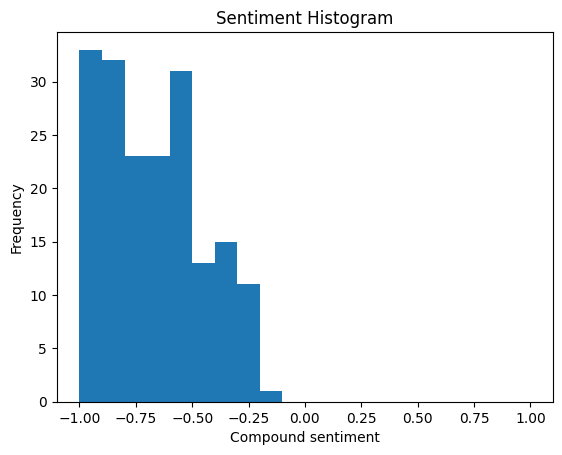

In [18]:
trump_data = []
for sentiment in trump_scores:
    trump_data.append(sentiment['compound'])

bins = np.arange(-1, 1.1, 0.1)
plt.hist(trump_data, bins=bins)

plt.title("Sentiment Histogram")
plt.xlabel("Compound sentiment")
plt.ylabel("Frequency")

### Biden tweets

In [ ]:
biden_sentiment_tweets = []

for tweet in generated_biden_tweets:
    biden_sentiment_tweets.append(tweet.splitlines())

biden_sentiment_tweets = [item for sublist in biden_sentiment_tweets for item in sublist]

sia = SentimentIntensityAnalyzer()

biden_negative_tweets = []
biden_scores = []
for tweet in biden_sentiment_tweets:
    sentiment_scores = sia.polarity_scores(tweet)
    if sentiment_scores['neg'] > 0.3:
        biden_scores.append(sentiment_scores)
        biden_negative_tweets.append(tweet)

In [ ]:
biden_data = []
for sentiment in biden_scores:
    biden_data.append(sentiment['compound'])

bins = np.arange(-1, 1.1, 0.1)
plt.hist(biden_data, bins=bins)

plt.title("Sentiment Histogram")
plt.xlabel("Compound sentiment")
plt.ylabel("Frequency")

## Wordcloud Generation

In [ ]:
# Obtener lista de signos de puntuación
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

### Trump tweets

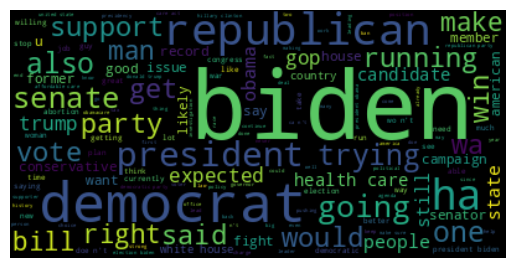

In [16]:
preprocessed_tweets = [preprocess_and_lemmatize(tweet) for tweet in generated_trump_tweets]

processed_tweets = ' '.join(preprocessed_tweets).strip()

wordcloud = WordCloud(stopwords=stop_words).generate(processed_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Biden tweets

In [ ]:
preprocessed_tweets = [preprocess_and_lemmatize(tweet) for tweet in generated_biden_tweets]

processed_tweets = ' '.join(preprocessed_tweets).strip()

wordcloud = WordCloud(stopwords=stop_words).generate(processed_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()